# Graph Neural Network Topic Classifier

In the following we will focus on building a model for topic classification based on a Graph Neural Network approach.

In particular in the following we will show you how to:

* Create a TF-IDF representation of the corpus, that will be used as node features in the Graph Neural Network model 
* Build, train a Graph Neural Network model and identify the best threshold for classifying documents 
* Test the performance of the model in a out-of-sample tests, following a truly inductive approach 

**NOTE: This Notebook can only be run after the 01_nlp_graph_creation notebook, as some of the results computed in the first notebook will be here reused.**

### Load Dataset

In [1]:
import nltk 

In [2]:
import numpy as np
import pandas as pd
import networkx as nx

In [3]:
corpus = pd.read_pickle("corpus.p")

In [4]:
corpus.head()

,label,clean_text,parsed,language
id,,,,
test/14826,[trade],ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,"(ASIAN, EXPORTERS, FEAR, DAMAGE, FROM, U.S.-JA...",en
test/14828,[grain],CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,"(CHINA, DAILY, SAYS, VERMIN, EAT, 7, -, 12, PC...",en
test/14829,"[crude, nat-gas]",JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,"(JAPAN, TO, REVISE, LONG, -, TERM, ENERGY, DEM...",en
test/14832,"[corn, grain, rice, rubber, sugar, tin, trade]",THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Th...,"(THAI, TRADE, DEFICIT, WIDENS, IN, FIRST, QUAR...",en
test/14833,"[palm-oil, veg-oil]",INDONESIA SEES CPO PRICE RISING SHARPLY Indon...,"(INDONESIA, SEES, CPO, PRICE, RISING, SHARPLY,...",en


In [5]:
from collections import Counter
topics = Counter([label for document_labels in corpus["label"] for label in document_labels]).most_common(10)

In [6]:
topics

[('earn', 3964),
 ('acq', 2369),
 ('money-fx', 717),
 ('grain', 582),
 ('crude', 578),
 ('trade', 485),
 ('interest', 478),
 ('ship', 286),
 ('wheat', 283),
 ('corn', 237)]

In [7]:
topicsList = [topic[0] for topic in topics]
topicsSet = set(topicsList)
dataset = corpus[corpus["label"].apply(lambda x: len(topicsSet.intersection(x))>0)]

In [8]:
def get_labels(corpus, topicsList=topicsList):
    return corpus["label"].apply(
        lambda labels: pd.Series({label: 1 for label in labels}).reindex(topicsList).fillna(0)
    )[topicsList]

In [9]:
labels = get_labels(dataset)

In [10]:
labels.head()

,earn,acq,money-fx,grain,crude,trade,interest,ship,wheat,corn
id,,,,,,,,,,
test/14826,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
test/14828,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
test/14829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
test/14832,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
test/14839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
def get_features(corpus):
    return corpus["parsed"]

In [12]:
def get_features_and_labels(corpus):
    return get_features(corpus), get_labels(corpus)

In [13]:
def train_test_split(corpus):
    train_idx = [idx for idx in corpus.index if "training/" in idx]
    test_idx = [idx for idx in corpus.index if "test/" in idx]
    return corpus.loc[train_idx], corpus.loc[test_idx]

In [14]:
train, test = train_test_split(dataset)

In [15]:
def my_spacy_tokenizer(pos_filter=["NOUN", "VERB", "PROPN"]):
    def tokenizer(doc):
        return [token.lemma_ for token in doc if (pos_filter is None) or (token.pos_ in pos_filter)] 
    return tokenizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
cntVectorizer = TfidfVectorizer(
    analyzer=my_spacy_tokenizer(),
    max_df = 0.25, min_df = 2, max_features = 10000
)

In [18]:
trainFeatures, _ = get_features_and_labels(train)
testFeatures, _ = get_features_and_labels(test)


In [19]:
trainedTransformed = cntVectorizer.fit_transform(trainFeatures)
testTransformed = cntVectorizer.transform(testFeatures)

In [20]:
features = pd.concat([
    pd.DataFrame.sparse.from_spmatrix(trainedTransformed, index=trainFeatures.index), 
    pd.DataFrame.sparse.from_spmatrix(testTransformed, index=testFeatures.index)
])

In [21]:
features.shape

(9034, 10000)

Creating the Graph

In [22]:
import stellargraph as sg
from stellargraph import StellarGraph, IndexedArray
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model

In [23]:
edges = pd.read_pickle("bipartiteEdges.p")

In [24]:
entityTypes = {entity: ith for ith, entity in enumerate(edges["type"].unique())}

In [25]:
entityTypes

{'keywords': 0, 'GPE': 1, 'ORG': 2, 'PERSON': 3}

In [26]:
documentFeatures = features.loc[set(corpus.index).intersection(features.index)] #.assign(document=1, entity=0)

In [27]:
documentFeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
id,,,,,,,,,,,,,,,,,,,,,
training/9238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test/15296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test/15287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
training/5938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test/21465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
entities = edges.groupby(["target", "type"])["source"].count().groupby(level=0).apply(
    lambda s: s.droplevel(0).reindex(entityTypes.keys()).fillna(0)
).unstack(level=1)

In [29]:
entityFeatures = (entities.T / entities.sum(axis=1)).T.assign(document=0, entity=1)

In [30]:
nodes = {"entity": entityFeatures, 
         "document": documentFeatures}

In [31]:
stellarGraph = StellarGraph(nodes, 
                            edges[edges["source"].isin(documentFeatures.index)], 
                            edge_type_column="type")

In [32]:
print(stellarGraph.info())

StellarGraph: Undirected multigraph
 Nodes: 23998, Edges: 86849

 Node types:
  entity: [14964]
    Features: float32 vector, length 6
    Edge types: entity-GPE->document, entity-ORG->document, entity-PERSON->document, entity-keywords->document
  document: [9034]
    Features: float32 vector, length 10000
    Edge types: document-GPE->entity, document-ORG->entity, document-PERSON->entity, document-keywords->entity

 Edge types:
    document-keywords->entity: [78838]
        Weights: range=[0.0827011, 1], mean=0.258464, std=0.0898612
        Features: none
    document-ORG->entity: [4129]
        Weights: range=[2, 22], mean=3.24122, std=2.30508
        Features: none
    document-GPE->entity: [2943]
        Weights: range=[2, 25], mean=3.25926, std=2.07008
        Features: none
    document-PERSON->entity: [939]
        Weights: range=[2, 14], mean=2.97444, std=1.65956
        Features: none


In [33]:
from stellargraph.data import EdgeSplitter

In [34]:
splitter = EdgeSplitter(stellarGraph)

In [35]:
graphTest, samplesTest, labelsTest = splitter.train_test_split(p=0.2)

** Sampled 17369 positive and 17369 negative edges. **


In [36]:
print(stellarGraph.info())

StellarGraph: Undirected multigraph
 Nodes: 23998, Edges: 86849

 Node types:
  entity: [14964]
    Features: float32 vector, length 6
    Edge types: entity-GPE->document, entity-ORG->document, entity-PERSON->document, entity-keywords->document
  document: [9034]
    Features: float32 vector, length 10000
    Edge types: document-GPE->entity, document-ORG->entity, document-PERSON->entity, document-keywords->entity

 Edge types:
    document-keywords->entity: [78838]
        Weights: range=[0.0827011, 1], mean=0.258464, std=0.0898612
        Features: none
    document-ORG->entity: [4129]
        Weights: range=[2, 22], mean=3.24122, std=2.30508
        Features: none
    document-GPE->entity: [2943]
        Weights: range=[2, 25], mean=3.25926, std=2.07008
        Features: none
    document-PERSON->entity: [939]
        Weights: range=[2, 14], mean=2.97444, std=1.65956
        Features: none


In [37]:
print(graphTest.info())

StellarGraph: Undirected multigraph
 Nodes: 23998, Edges: 69480

 Node types:
  entity: [14964]
    Features: float32 vector, length 6
    Edge types: entity-GPE->document, entity-ORG->document, entity-PERSON->document, entity-keywords->document
  document: [9034]
    Features: float32 vector, length 10000
    Edge types: document-GPE->entity, document-ORG->entity, document-PERSON->entity, document-keywords->entity

 Edge types:
    document-keywords->entity: [63057]
        Weights: range=[0.0827011, 1], mean=0.258427, std=0.0899773
        Features: none
    document-ORG->entity: [3296]
        Weights: range=[2, 22], mean=3.21572, std=2.2592
        Features: none
    document-GPE->entity: [2360]
        Weights: range=[2, 19], mean=3.24237, std=2.01535
        Features: none
    document-PERSON->entity: [767]
        Weights: range=[2, 14], mean=3, std=1.69163
        Features: none


## Creating a Topic Classification Model 

We start by splitting the data into train, validation and test

In [48]:
targets = labels.reindex(documentFeatures.index).fillna(0)
#documentFeatures.drop(["entity", "document"], axis=1)

In [49]:
targets.head()

,earn,acq,money-fx,grain,crude,trade,interest,ship,wheat,corn
id,,,,,,,,,,
test/16678,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test/15913,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
training/12032,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
training/8366,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
training/10454,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
def train_test_split(corpus):
    graphIndex = [index for index in corpus.index]
    
    train_idx = [idx for idx in graphIndex if "training/" in idx]
    test_idx = [idx for idx in graphIndex if "test/" in idx]
    return corpus.loc[train_idx], corpus.loc[test_idx]

In [51]:
sampled, hold_out = train_test_split(targets)

In [52]:
allNeighbors = np.unique([n for node in sampled.index for n in stellarGraph.neighbors(node)])

In [53]:
subgraph = stellarGraph.subgraph(set(sampled.index).union(allNeighbors))

In [54]:
print(subgraph.info())

StellarGraph: Undirected multigraph
 Nodes: 16927, Edges: 62454

 Node types:
  entity: [10438]
    Features: float32 vector, length 6
    Edge types: entity-GPE->document, entity-ORG->document, entity-PERSON->document, entity-keywords->document
  document: [6489]
    Features: float32 vector, length 10000
    Edge types: document-GPE->entity, document-ORG->entity, document-PERSON->entity, document-keywords->entity

 Edge types:
    document-keywords->entity: [56647]
        Weights: range=[0.0918226, 1], mean=0.25739, std=0.0888008
        Features: none
    document-ORG->entity: [3032]
        Weights: range=[2, 22], mean=3.20877, std=2.21143
        Features: none
    document-GPE->entity: [2104]
        Weights: range=[2, 25], mean=3.25808, std=2.08119
        Features: none
    document-PERSON->entity: [671]
        Weights: range=[2, 14], mean=2.97615, std=1.66958
        Features: none


In [55]:
from sklearn.model_selection import train_test_split

train, leftOut = train_test_split(
    sampled,
    train_size=0.1,
    test_size=None,
    random_state=42,
)

validation, test = train_test_split(
    leftOut, train_size=0.2, test_size=None, random_state=100,
)

In [56]:
validation = validation[validation.sum(axis=1) > 0]
test = test[test.sum(axis=1) > 0]

In [57]:
print(f"Validation: {validation.shape}")
print(f"Test: {test.shape}")

Validation: (1168, 10)
Test: (4673, 10)


### Training the Model

We start  by creating the model 

In [58]:
batch_size = 50
num_samples = [10, 5]

In [59]:
from stellargraph.mapper import HinSAGENodeGenerator

generator = HinSAGENodeGenerator(subgraph, batch_size, num_samples, head_node_type="document")

In [60]:
from stellargraph.layer import HinSAGE

graphsage_model = HinSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

In [61]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train.shape[1], activation="sigmoid")(x_out)

In [62]:
prediction.shape

TensorShape([None, 10])

In [63]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)


We now train the model 

In [64]:
train_gen = generator.flow(train.index, train, shuffle=True)

In [65]:
val_gen = generator.flow(validation.index, validation)

In [66]:
history = model.fit(
    train_gen, epochs=50, validation_data=val_gen, verbose=1, shuffle=False
)

Epoch 1/50
13/13 [==============================] - 215s 17s/step - loss: 0.6139 - acc: 0.1365 - val_loss: 0.4780 - val_acc: 0.4401
Epoch 2/50
13/13 [==============================] - 169s 13s/step - loss: 0.4675 - acc: 0.4323 - val_loss: 0.4001 - val_acc: 0.4401
Epoch 3/50
13/13 [==============================] - 162s 13s/step - loss: 0.3973 - acc: 0.4319 - val_loss: 0.3486 - val_acc: 0.4401
Epoch 4/50
13/13 [==============================] - 153s 12s/step - loss: 0.3447 - acc: 0.4604 - val_loss: 0.3124 - val_acc: 0.4401
Epoch 5/50
13/13 [==============================] - 144s 11s/step - loss: 0.3090 - acc: 0.4997 - val_loss: 0.2853 - val_acc: 0.4932
Epoch 6/50
13/13 [==============================] - 159s 13s/step - loss: 0.2886 - acc: 0.5484 - val_loss: 0.2639 - val_acc: 0.6045
Epoch 7/50
13/13 [==============================] - 187s 15s/step - loss: 0.2612 - acc: 0.6354 - val_loss: 0.2453 - val_acc: 0.6387
Epoch 8/50
13/13 [==============================] - 203s 16s/step - loss: 0.

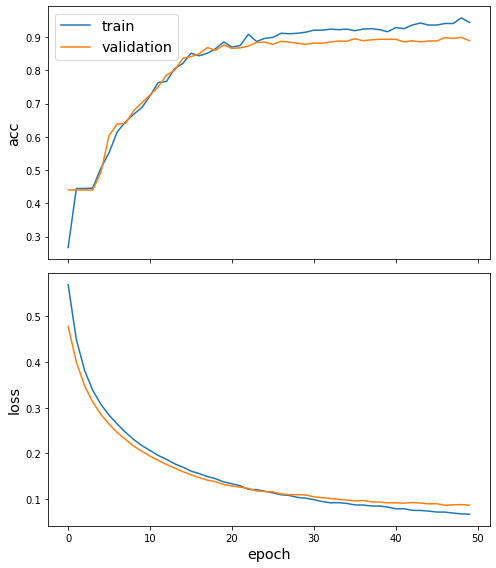

In [67]:
sg.utils.plot_history(history)

In [ ]:
history = model.fit(
    train_gen, epochs=50, validation_data=val_gen, verbose=1, shuffle=False
)

In [ ]:
sg.utils.plot_history(history)

### Threshold identification

In [69]:
test_gen = generator.flow(test.index, test)

In [70]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

94/94 [==============================] - 391s 4s/step - loss: 0.0933 - acc: 0.8795

Test Set Metrics:
	loss: 0.0933
	acc: 0.8795


In [71]:
test_predictions = pd.DataFrame(model.predict(test_gen), index=test.index, columns=test.columns)

In [72]:
test_results = pd.concat({
    "target": test, 
    "preds": test_predictions
}, axis=1)

In [73]:
from sklearn.metrics import f1_score, classification_report

<AxesSubplot:>

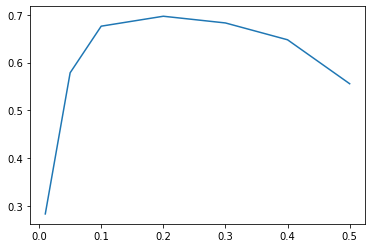

In [74]:
f1s = {}

for th in [0.01,0.05,0.1,0.2,0.3,0.4,0.5]:
    f1s[th] = f1_score(test_results["target"], 1.0*(test_results["preds"]>th), average="macro")
    
pd.Series(f1s).plot()

As it can be seen, with a threshold of about 0.2 we obtain the best performances. We thus use this value for producing the classification report

In [75]:
print(classification_report(test_results["target"], 1.0*(test_results["preds"]>0.2)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2075
           1       0.85      0.96      0.90      1200
           2       0.65      0.90      0.75       364
           3       0.83      0.95      0.89       305
           4       0.86      0.68      0.76       296
           5       0.74      0.56      0.63       269
           6       0.60      0.80      0.69       245
           7       0.62      0.10      0.17       150
           8       0.49      0.95      0.65       149
           9       0.44      0.88      0.58       129

   micro avg       0.80      0.89      0.84      5182
   macro avg       0.70      0.78      0.70      5182
weighted avg       0.82      0.89      0.84      5182
 samples avg       0.83      0.90      0.85      5182



/Users/deusebio/.pyenv/versions/3.7.6/envs/ml-book-7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Inductive Prediction

We now provide a prediction truly inductive, thus we will be using the full graph and we will also use the threshold of 0.2 we have identified above as the one providing the top f1-score.  

In [76]:
generator = HinSAGENodeGenerator(stellarGraph, batch_size, num_samples, head_node_type="document")

In [77]:
hold_out = hold_out[hold_out.sum(axis=1) > 0]

In [78]:
hold_out_gen = generator.flow(hold_out.index, hold_out)

In [79]:
hold_out_predictions = model.predict(hold_out_gen)

In [80]:
preds = pd.DataFrame(1.0*(hold_out_predictions > 0.2), index=hold_out.index, columns=hold_out.columns)

In [81]:
results = pd.concat({
    "target": hold_out, 
    "preds": preds
}, axis=1)

In [82]:
print(classification_report(results["target"], results["preds"]))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1087
           1       0.90      0.97      0.93       719
           2       0.64      0.92      0.76       179
           3       0.82      0.95      0.88       149
           4       0.85      0.62      0.72       189
           5       0.74      0.50      0.59       117
           6       0.60      0.79      0.68       131
           7       0.43      0.03      0.06        89
           8       0.50      0.96      0.66        71
           9       0.39      0.86      0.54        56

   micro avg       0.82      0.89      0.85      2787
   macro avg       0.68      0.76      0.68      2787
weighted avg       0.83      0.89      0.84      2787
 samples avg       0.84      0.90      0.86      2787



/Users/deusebio/.pyenv/versions/3.7.6/envs/ml-book-7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
